In [1]:
## import modules
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import Tensor
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import sys
sys.path.append('../')

from pytorch_utils.data_pipeline import TSData

## Data loader for a sequential model

* For the training loader, we use a window size of 100 time steps from the range 1980-01-01 to 2000-12-31
* For the validation loader, we use the entire sequence 2001-01-01 to 2020-12-31

In [37]:
## load data from csv to Xarray dataset
df = pd.read_csv('../simple_gpp_model/data/predictor-variables+GPP_Jena.csv', index_col=0, parse_dates=True)
ds = df.to_xarray().rename({'index': 'time'})
ds = ds.sel(time=slice('1982-01-15', None)) # FAPAR is NaN the first two weeks

/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_69120/2196315113.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2016'][variables].plot(subplots=True, layout=(4,2), figsize=(14,10))


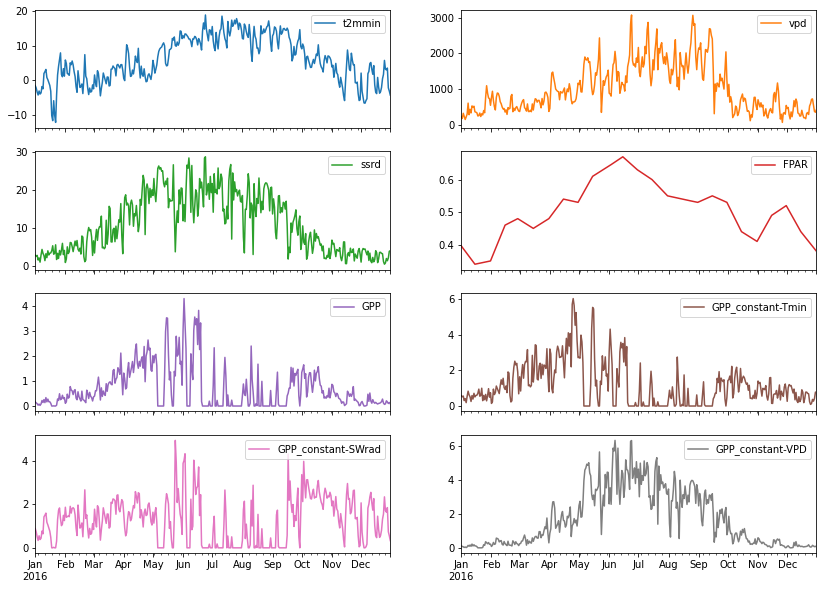

In [3]:
variables = ['t2mmin', 'vpd', 'ssrd', 'FPAR', 'GPP', 'GPP_constant-Tmin', 'GPP_constant-SWrad', 'GPP_constant-VPD']
df['2016'][variables].plot(subplots=True, layout=(4,2), figsize=(14,10))
plt.show()

In [94]:
train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('1982', '2000'),
           #normalize=False,
          ),
    batch_size=50,
    shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('2001', '2016'), 
           #normalize=False,
           return_seq=True,
           ts_window_size=-1,
           norm_stats=train_loader.dataset.norm_stats
          ), 
    batch_size=1,
    shuffle=False)

## We can iterate the data in batches of size 50

In [5]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)

    if i > 3:
        break


torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])


In [6]:
class FCN(nn.Module):
    def __init__(
            self,
            num_feature: int,
            num_targets: int=1,
            num_hidden: int=8,
            num_layers: int=2,
            dropout: float = 0.0,
            activation: nn.Module = nn.Sigmoid,
            output_activation: nn.Module = nn.Identity,
            learning_rate: float = 0.001,
            weight_decay: float = 0.0) -> None:
        
        """A fully connected feed-forward model.
        
        Parameters
        -----------
        num_features: int
            The number of input features.
        num_targets: int (default is 1)
            The number of targets.
        num_hidden: int (default is 8)
            The number of hidden nodes per layer.
        num_layers: int (default is 2)
            The number of hidden nodes.
        dropout: float (default is 0.0)
            The dropout used in all hidden layers.
        activation: nn.Module (default is nn.Sigmoid)
            The activation function.
        output_activation: nn.Module (default is nn.Identity)
            The output activation function, default is nn.Identity and does not transform the output.
        learning_rate: float (default is 0.001):
            The learning rate.
        weight_decay: float (default is 0.0)
            The weight decay (L2 regularization).
        """
        
        super().__init__()

        layers = OrderedDict()
        in_sizes = [num_feature] + [num_hidden] * num_layers
        out_sizes = [num_hidden] * num_layers + [num_targets]

        for i, (nin, nout) in enumerate(zip(in_sizes, out_sizes)):
            is_input_layer = i == 0
            is_output_layer = i == num_layers

            layers.update({f'linear{i}': nn.Linear(in_features=nin, out_features=nout)})

            if not is_input_layer and not is_output_layer:
                layers.update({f'dropout{i}': nn.Dropout(dropout)})

            if is_output_layer:
                layers.update({f'activation{i}': output_activation()})
            else:
                layers.update({f'activation{i}': activation()})

        self.model = nn.Sequential(layers)

        self.optimizer = self.get_optimizer(self.model.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

        #@todo: add scaling by target magnitude to increase preformance for high values (Albrecht's idea)
        self.loss_fn = nn.MSELoss()

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def train_epoch(self, train_loader: torch.utils.data.DataLoader) -> Tensor:
        self.train()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in train_loader:
            self.optimizer.zero_grad()

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            self.optimizer.step()

            loss_sum += loss.item()
            loss_counter += 1
        
        return (loss_sum / loss_counter).item()

    @torch.no_grad()
    def eval_epoch(self, valid_loader: torch.utils.data.DataLoader) -> Tensor:
        self.eval()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in valid_loader:

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)

        loss_sum += loss.item()
        loss_counter += 1

        return (loss_sum / loss_counter).item()

    def tune(self, num_epochs: int, train_loader: torch.utils.data.DataLoader, valid_loader: torch.utils.data.DataLoader) -> None:
        self.train_losses = np.zeros(num_epochs)
        self.valid_losses = np.zeros(num_epochs)

        train_loss = -1
        valid_loss = -1
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            pbar.set_description(f'train loss: {train_loss}, valid loss: {valid_loss}')

            train_loss = self.train_epoch(train_loader=train_loader)
            valid_loss = self.eval_epoch(valid_loader=valid_loader)

            self.train_losses[epoch] = train_loss
            self.valid_losses[epoch] = valid_loss

    def get_optimizer(self, params: torch.ParameterDict, learning_rate: float = 0.001, weight_decay: float = 0.0) -> torch.optim.Optimizer:
        return torch.optim.AdamW(params, lr=learning_rate, weight_decay=weight_decay)


In [7]:
model = FCN(num_feature=4, learning_rate=0.1)

In [8]:
model.tune(num_epochs=3, train_loader=train_loader, valid_loader=valid_loader)

train loss: 0.03730270266532898, valid loss: 0.0003104842617176473: 100%|███████████████████████████████████████████████████████████| 3/3 [01:31<00:00, 30.65s/it]


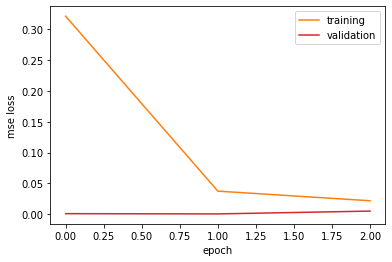

In [18]:
plt.plot(model.train_losses, label='training', color='tab:orange')
plt.plot(model.valid_losses, label='validation', color='tab:red')

plt.xlabel('epoch')
plt.ylabel('mse loss')

plt.legend()

### Make plot to see preformance

In [19]:
predictor, target = next(iter(train_loader))
target = target.detach().numpy()

In [20]:
target_pred = model(predictor).detach().numpy()

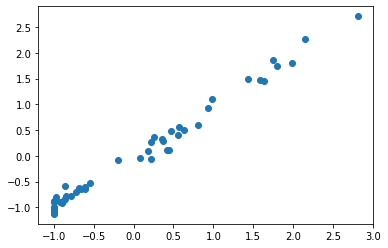

In [21]:
plt.scatter(target, target_pred)

### Attribution

In [22]:
prediction_data_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('1982', '2016'), 
           #normalize=False,
           norm_stats=train_loader.dataset.norm_stats
          ), 
    batch_size=12770,
    shuffle=False)

In [14]:
ds['t2mmin_constant'] = 10

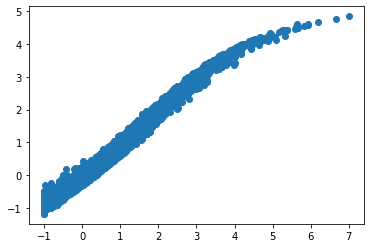

In [23]:
predictor, target = next(iter(prediction_data_loader))
target = target.detach().numpy()
target_pred = model(predictor).detach().numpy()
plt.scatter(target, target_pred)

In [16]:
target

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       ...,
       [-0.84399784],
       [-0.78084254],
       [-0.8657092 ]], dtype=float32)

In [26]:
target = prediction_data_loader.dataset.denorm_np(target.squeeze() , 'GPP')
target_pred = prediction_data_loader.dataset.denorm_np(target_pred.squeeze() , 'GPP')

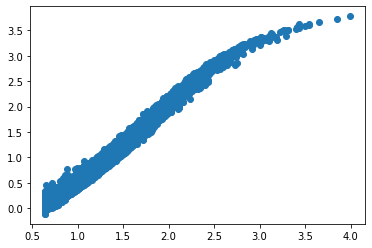

In [27]:
plt.scatter(target, target_pred)

In [39]:
df = ds.to_dataframe()

In [41]:
df['GPP_pred'] = target_pred

/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_69120/291046286.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2001'][['GPP_pred', 'GPP']].plot()


<AxesSubplot:xlabel='time'>

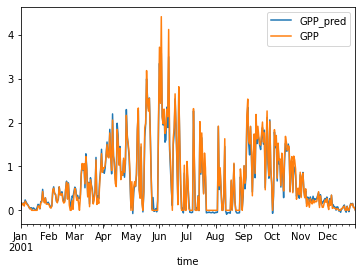

In [43]:
df['2001'][['GPP_pred', 'GPP']].plot()

### Set Tmin to constant (10 degrees)

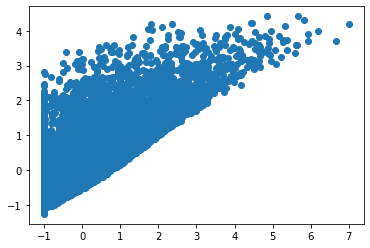

In [52]:
ds['t2mmin_constant'] = 10

train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin_constant', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('1982', '2000'),
           #normalize=False,
          ),
    batch_size=50,
    shuffle=True)

prediction_data_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin_constant', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('1982', '2016'), 
           #normalize=False,
           norm_stats=train_loader.dataset.norm_stats
          ), 
    batch_size=12770,
    shuffle=False)

predictor, target = next(iter(prediction_data_loader))
target = target.detach().numpy()
target_pred = model(predictor).detach().numpy()
plt.scatter(target, target_pred)

In [53]:
target = prediction_data_loader.dataset.denorm_np(target.squeeze() , 'GPP')
target_pred = prediction_data_loader.dataset.denorm_np(target_pred.squeeze() , 'GPP')
df['GPP_pred_constant-t2mmin'] = target_pred

/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_69120/4214555891.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2001'][['GPP_pred_constant-t2mmin', 'GPP_constant-Tmin']].plot()


<AxesSubplot:xlabel='time'>

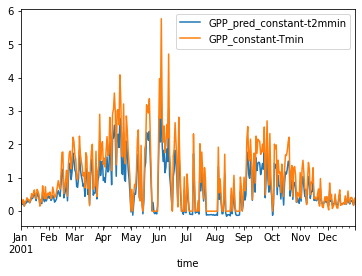

In [55]:
df['2001'][['GPP_pred_constant-t2mmin', 'GPP_constant-Tmin']].plot()

### Set VPD to constant (1000)

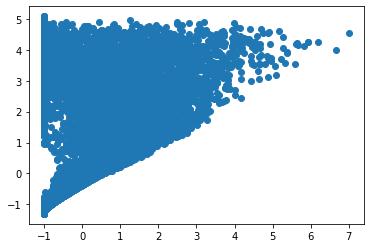

In [56]:
ds['vpd_constant'] = 1000

train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd_constant', 'FPAR'], targets='GPP', time_slice=slice('1982', '2000'),
           #normalize=False,
          ),
    batch_size=50,
    shuffle=True)

prediction_data_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd_constant', 'FPAR'], targets='GPP', time_slice=slice('1982', '2016'), 
           #normalize=False,
           norm_stats=train_loader.dataset.norm_stats
          ), 
    batch_size=12770,
    shuffle=False)

predictor, target = next(iter(prediction_data_loader))
target = target.detach().numpy()
target_pred = model(predictor).detach().numpy()
plt.scatter(target, target_pred)

In [57]:
target = prediction_data_loader.dataset.denorm_np(target.squeeze() , 'GPP')
target_pred = prediction_data_loader.dataset.denorm_np(target_pred.squeeze() , 'GPP')
df['GPP_pred_constant-VPD'] = target_pred

/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_69120/1535029827.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2001'][['GPP_pred_constant-VPD', 'GPP_constant-VPD']].plot.scatter(x='GPP_pred_constant-VPD', y='GPP_constant-VPD')


<AxesSubplot:xlabel='GPP_pred_constant-VPD', ylabel='GPP_constant-VPD'>

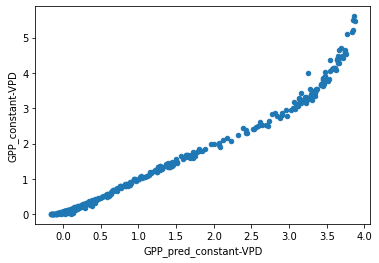

In [60]:
df['2001'][['GPP_pred_constant-VPD', 'GPP_constant-VPD']].plot.scatter(x='GPP_pred_constant-VPD', y='GPP_constant-VPD')

### Set SWrad to constant (15)

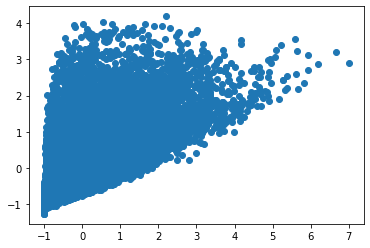

In [62]:
ds['ssrd_constant'] = 15

train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd_constant', 't2mmin', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('1982', '2000'),
           #normalize=False,
          ),
    batch_size=50,
    shuffle=True)

prediction_data_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd_constant', 't2mmin', 'vpd', 'FPAR'], targets='GPP', time_slice=slice('1982', '2016'), 
           #normalize=False,
           norm_stats=train_loader.dataset.norm_stats
          ), 
    batch_size=12770,
    shuffle=False)

predictor, target = next(iter(prediction_data_loader))
target = target.detach().numpy()
target_pred = model(predictor).detach().numpy()
plt.scatter(target, target_pred)

In [63]:
target = prediction_data_loader.dataset.denorm_np(target.squeeze() , 'GPP')
target_pred = prediction_data_loader.dataset.denorm_np(target_pred.squeeze() , 'GPP')
df['GPP_pred_constant-SSRD'] = target_pred

In [64]:
df

,longitude,latitude,ssrd,t2mmin,vpd,FPAR,GPP,GPP_constant-Tmin,GPP_constant-SWrad,GPP_constant-VPD,GPP_pred,GPP_pred_constant-t2mmin,GPP_pred_constant-VPD,GPP_pred_constant-SSRD
time,,,,,,,,,,,,,,
1982-01-15,11.625,50.875,4.730988,-11.207062,367.01416,0.18000,0.000000,0.446440,0.000000,0.000000,-0.013911,0.436567,-0.150940,0.039424
1982-01-16,11.625,50.875,4.677718,-7.569855,361.99496,0.18000,0.000000,0.441413,0.000000,0.000000,0.028526,0.432566,-0.111351,0.115415
1982-01-17,11.625,50.875,4.862544,-8.214752,331.22617,0.18000,0.000000,0.458854,0.000000,0.000000,0.028779,0.461621,-0.118554,0.105812
1982-01-18,11.625,50.875,3.893224,-6.850739,272.10287,0.18000,0.000000,0.367384,0.000000,0.000000,0.033643,0.376887,-0.108543,0.150942
1982-01-19,11.625,50.875,4.660599,-5.529327,251.45564,0.18000,0.012974,0.439797,0.041757,0.008433,0.075265,0.465199,-0.078424,0.196729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,11.625,50.875,1.927548,3.046326,721.71110,0.39500,0.210279,0.370535,1.636368,0.147238,0.229461,0.282110,0.176063,1.165604
2016-12-28,11.625,50.875,1.329699,3.564880,545.58264,0.39125,0.163670,0.272738,1.846323,0.106386,0.212095,0.241791,0.152753,1.371897
2016-12-29,11.625,50.875,2.053320,-2.143768,372.87292,0.38750,0.100903,0.417126,0.737118,0.065587,0.110862,0.321675,0.006240,0.605266


/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_69120/3811648154.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2001'].plot.scatter(x='GPP_pred_constant-SSRD', y='GPP_constant-SWrad')


<AxesSubplot:xlabel='GPP_pred_constant-SSRD', ylabel='GPP_constant-SWrad'>

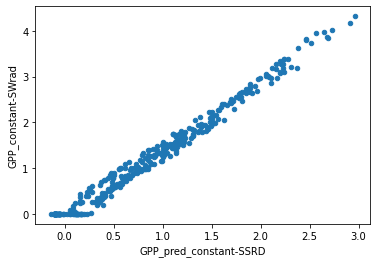

In [65]:
df['2001'].plot.scatter(x='GPP_pred_constant-SSRD', y='GPP_constant-SWrad')

/var/folders/2w/42tyxprs709fpx349_dvqqqr0000gq/T/ipykernel_69120/750496137.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2003'][['GPP_pred_constant-SSRD', 'GPP_constant-SWrad']].plot()


<AxesSubplot:xlabel='time'>

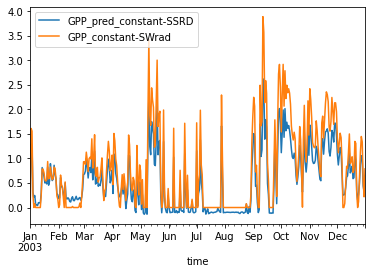

In [68]:
df['2003'][['GPP_pred_constant-SSRD', 'GPP_constant-SWrad']].plot()

In [183]:
def compute_integrated_gradient(batch_x, batch_blank, model):
    mean_grad = 0
    n = 100

    for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x)
        (grad,) = torch.autograd.grad(y, x)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients, mean_grad

In [186]:
batch_x, batch_y = next(iter(valid_loader))

In [187]:
batch_y_hat = model(batch_x)

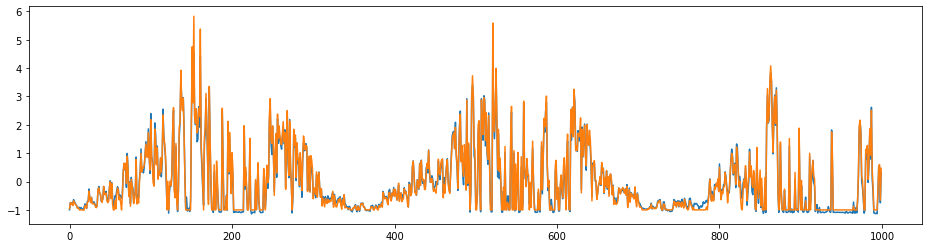

In [188]:
plt.figure(figsize=(16, 4))
plt.plot(batch_y_hat.detach().numpy().squeeze()[:1000])
plt.plot(batch_y.detach().numpy().squeeze()[:1000])

In [228]:
batch_x_bl = torch.zeros_like(batch_x)
##@todo: add normalization of zeros based on predictor normalization - probably does not play a big role here

In [229]:
n = batch_x.shape[1]
intgrads = np.empty((n,4), dtype=np.float32)

In [230]:
for i in tqdm(range(n)):

    intgrds = compute_integrated_gradient(batch_x[0,i,:], batch_x_bl[0,i,:], model)
    it, mn = intgrds
    intgrads[i,:] = it

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5844/5844 [01:42<00:00, 57.12it/s]


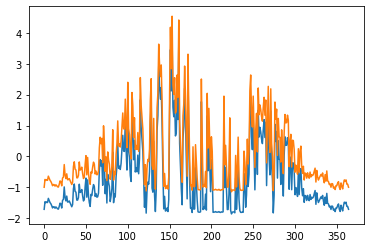

In [240]:
plt.plot(intgrads[0*365:1*365,:].sum(axis=1))
plt.plot(batch_y_hat.detach().squeeze()[0*365:1*365])

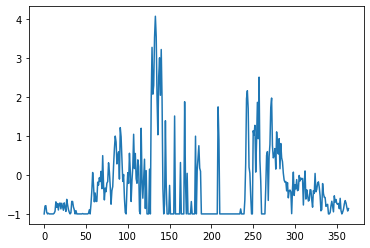

In [237]:
plt.plot(batch_y.detach().squeeze()[2*365:3*365])

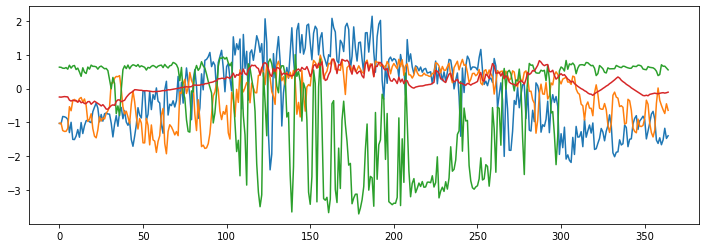

In [244]:
plt.figure(figsize=(12,4))
plt.plot(intgrads[3*365:4*365,:])

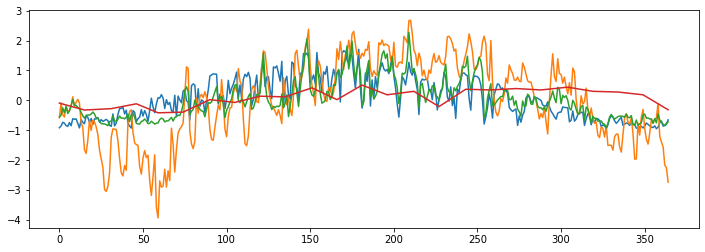

In [243]:
plt.figure(figsize=(12,4))
plt.plot(batch_x.detach().squeeze()[4*365:5*365,:])

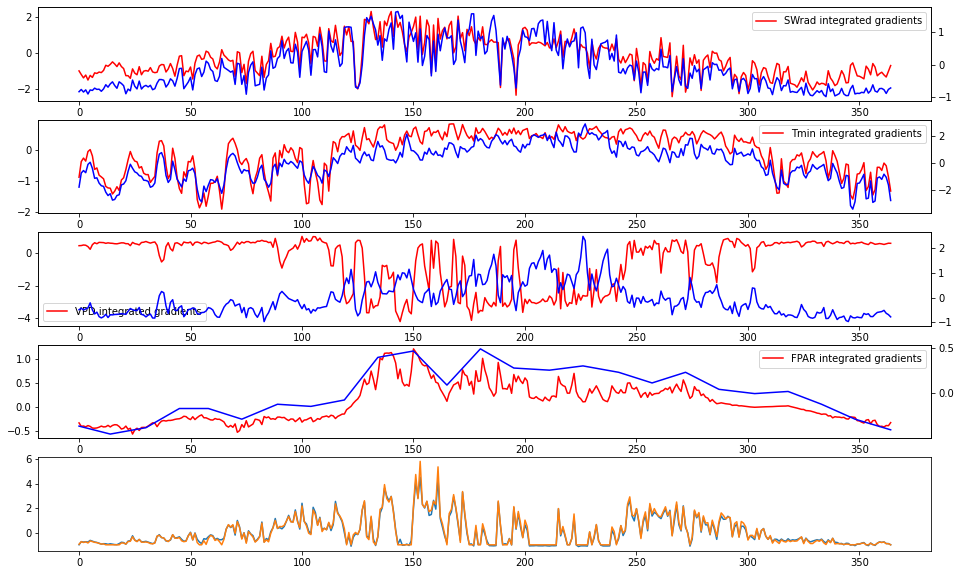

In [210]:
fig, axes = plt.subplots(5, 1, figsize=(16, 10))

ax = axes[0]
ax2 = ax.twinx()
ax = ax.plot(intgrads[:365,0], c='r', label='SWrad integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365,0], c='b', label='SWrad')

ax = axes[1]
ax2 = ax.twinx()
ax.plot(intgrads[:365,1], c='r',  label='Tmin integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365,1], c='b', label='Tmin')

ax = axes[2]
ax2 = ax.twinx()
ax.plot(intgrads[:365,2], c='r', label='VPD integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365,2], c='b', label='VPD')

ax = axes[3]
ax2 = ax.twinx()
ax.plot(intgrads[:365,3], c='r', label='FPAR integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365,3], c='b', label='FPAR')

axes[4].plot(batch_y_hat.detach().squeeze()[:365], label='GPP predicted')
axes[4].plot(batch_y.detach().squeeze()[:365], label='GPP')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

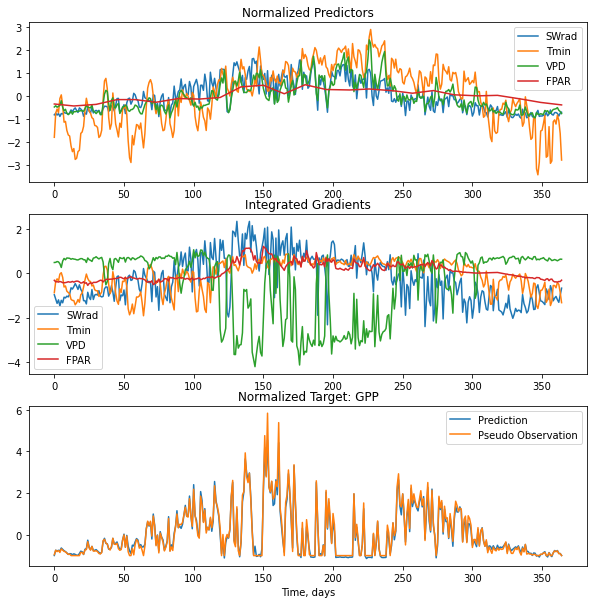

In [253]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].set_title('Normalized Predictors')
axes[0].plot(batch_x.detach().squeeze()[:365,:])
axes[0].legend(['SWrad', 'Tmin', 'VPD', 'FPAR'])

axes[1].set_title('Integrated Gradients')
axes[1].plot(intgrads[:365,:])
axes[1].legend(['SWrad', 'Tmin', 'VPD', 'FPAR'])

axes[2].set_title('Normalized Target: GPP')
axes[2].plot(batch_y_hat.detach().squeeze()[:365], label='Prediction')
axes[2].plot(batch_y.detach().squeeze()[:365], label='Pseudo Observation')
axes[2].legend()

axes[2].set_xlabel('Time, days')
plt.savefig('../plots/Integrated-Gradients_GPP_Teaser.png', dpi=300)